In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
from IPython.display import clear_output

import jax.numpy as jnp

In [2]:
pkl_file = open(f'results/gibbs_states.pkl', 'rb')
data = pickle.load(pkl_file) # <- dict 
pkl_file.close()
print('Data keys', data.keys())

# unpack Gibbs-states
x = data['x']
f_true = data['f_true']
inital_state = data['initial_state']
gibbs_states = data['gibbs_states']

print('\nGibbs-state keys:')
# print all keys and len/shape of corresponding data
for k in gibbs_states.position.keys():
    try:
        print('    ', k, 
              gibbs_states.position[k]
              if len(gibbs_states.position[k].shape) == 0 
              else gibbs_states.position[k].shape, 
              end='\n')
    except:
        print('    ', k, len(gibbs_states.position[k]), end='\n')
print()

Data keys dict_keys(['x', 'f_true', 'initial_state', 'gibbs_states'])

Gibbs-state keys:
     Z (20000, 20)
     dev 5
     f (20000, 100)
     lengthscale (20000,)
     mean (20000, 20)
     obs_noise (20000,)
     scale (20000, 20)
     u (20000, 20)
     variance (20000,)



## posterior

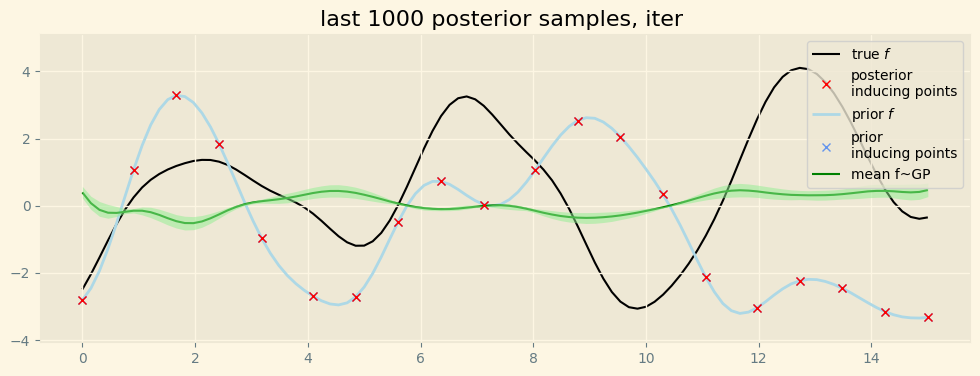

In [3]:

def plot_posterior_samples(gibbs_state_hist, initial_state, num_of_samples=100, iter='', idx_x=None):
    """
    Plot true function and posterior samples
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    # plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    plt.plot(
        gibbs_state_hist.position['Z'][-1], 
        gibbs_state_hist.position['u'][-1], 
        'x', 
        label='posterior\ninducing points', 
        color='red',
        alpha=1,
        zorder=2)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)

    # get last `num_of_states` gibbs states
    f_samples = gibbs_state_hist.position['f'][-1*num_of_samples -1: -1]

    # plot each sample
    '''for i in range(f_samples.shape[0]):  # negativ indexing to select last elements
        plt.plot(x, f_samples[i], 
                color='orange',
                alpha=0.1)'''
        
    # plot average and confidence intervals
    f_mean = jnp.mean(f_samples, axis=0)
    f_hdi_lower = jnp.percentile(f_samples, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_samples, q=97.5, axis=0)
    ax = plt.gca()
    ax.plot(x, f_mean, label='mean f~GP', color='green', lw=1.5, zorder=1)
    ax.fill_between(
        x.flatten(), f_hdi_lower, f_hdi_upper, 
        alpha=0.5, color='lightgreen', lw=0)
    
    ax.set_ylim(
        jnp.min(f_true) - 1, 
        jnp.max(f_true) + 1)

    plt.title(f'last {f_samples.shape[0]} posterior samples, iter {iter}')
    plt.legend()
    # plt.savefig(f'results/posterior_iter{iter}.png')
    # plt.savefig(f'results/posterior.png')
    plt.show()
    # plt.close()

plot_posterior_samples(
    gibbs_states, 
    inital_state,
    num_of_samples=1000)

290


KeyboardInterrupt: 

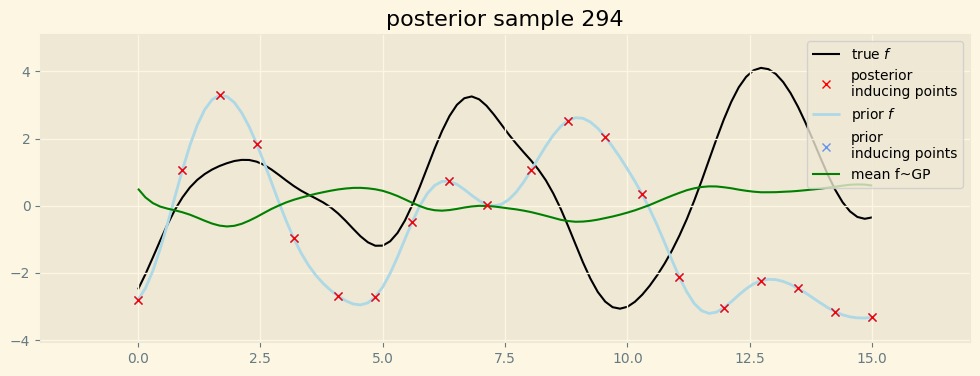

In [4]:
# plot single posterior samples
def plot_posterior_sample(gibbs_state_hist, initial_state, idx, save_fig=False):
    """
    Plot true function and posterior samples
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    # plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    # inducing points
    plt.plot(
        gibbs_state_hist.position['Z'][idx], 
        gibbs_state_hist.position['u'][idx], 
        'x', 
        label='posterior\ninducing points', 
        color='red',
        alpha=1,
        zorder=2)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)

    # posterior f
    plt.plot(
        x,
        gibbs_state_hist.position['f'][idx], 
        label='mean f~GP', 
        color='green',
        lw=1.5, 
        zorder=1)
    
    plt.ylim(
        jnp.min(f_true) - 1, 
        jnp.max(f_true) + 1)
    plt.xlim(
        jnp.min(-2), 
        jnp.max(17))

    plt.title(f'posterior sample {idx}')
    plt.legend()
    if save_fig:
        plt.savefig(f'results/plots/posterior_{idx}.png')
        plt.close()
    else:
        plt.show()

iters = list(range(0, 1000)) #+ list(range(1000, 51_000, 1000))
for c, i in enumerate(iters):
    plot_posterior_sample(
        gibbs_states,
        inital_state,
        idx=i, 
        save_fig=True)

    if c%10 == 0:
        clear_output()
        print(i)

## u-trajectories

In [ ]:
# get variance along time-axis to quantify 'spread'
# this helps ploting groups of similar u trajectories
spread = np.var(gibbs_states.position['u'][100:], axis=0)

plt.bar(
    range(0, gibbs_states.position['u'].shape[1]), 
    spread)

bins = np.digitize(spread, bins=[.0005])
unique_bins = np.unique(bins)
idx_list = []
for i in unique_bins:
    idx_list.append(np.where(bins == i)[0])
    print(idx_list[-1])

In [ ]:
def plot_trajectories(u_samples, title=''):
    # plot u trajectories
    
    iter_idx = range(len(u_samples))
    color = plt.cm.hsv(np.linspace(0, 1, u_samples.shape[1]))

    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    ax.set_facecolor('grey')
    for i in range(u_samples.shape[1]):
        plt.plot(iter_idx, u_samples[:, i], alpha=0.7, color=color[i], lw=1)
    plt.xlabel('Gibbs iterations')
    plt.title(title)
    # plt.savefig(f'results/train_hist_{gibbs_key}.png')
    plt.show()
    # plt.close()

u_samples = gibbs_states.position['u']

u_idx = idx_list[0]
plot_trajectories(
    u_samples[100:, u_idx],
    title=f'u samples {u_idx}\nexcluded samples at the beginning')

u_idx = idx_list[1]
plot_trajectories(
    u_samples[100:, u_idx],
    title=f'u samples {u_idx}\nexcluded samples at the beginning')

# first x samples for all u's
u_idx = list(range(u_samples.shape[-1]))
plot_trajectories(
    u_samples[:10000, u_idx],
    title=f'u samples {u_idx}')